In [1]:
function grad(param,x,y_exact,theta)
    N = param.N
    Q = param.Q
    h = 2/Q
    k = 1/N
    r = param.r

    fhat, z, dzn, dzw, dzb = forward(param,x,theta)

    a = theta.a
    c = theta.c
    w = theta.w
    b = theta.b

    Pn = zeros(Q,N)
    Pn[:,N] = dzn[:,N]
    for j = N-1:-1:1
        Pn[:,j] = Pn[:,j+1] .* dzn[:,j]
    end

    L = 0
    y_diff = y_exact[1:Q] - fhat[1:Q]

    L_main = h*sum(y_diff.^2)

    L = L + r*k*sum(w.^2+b.^2)

    L = L + r/k*sum((w[2:N]-w[1:N-1]).^2 + (b[2:N]-b[1:N-1]).^2)

    dLda = 0
    dLdc = 0
    dLdw = zeros(N)
    dLdb = zeros(N)

    

    # derivative L with a
    dLda = 2 * a * r - 2 * c * h * sum((y_diff.* Pn[:,1] .* x))

    # derivative L with c
    dLdc = 2 * c * r - 2 * h * sum(y_diff .* z[:,N+1])

    # derivative L with w
    dLdw[1] = 2*r/k*(w[1]-w[2])+ 2*r*k*w[1] - 2*c*h*sum(y_diff.*Pn[:,2].*dzw[:,1])
    dLdw[N] = 2*r/k*(w[N]-w[N-1])+ 2*r*k*w[N] - 2*c*h*sum(y_diff.*dzw[:,N])
    for j=2:N-1
        dLdw[j] = 2*r/k*(2*w[j]-w[j-1]-w[j+1])+ 2*r*k*w[j] - 2*c*h*sum(y_diff.*Pn[:,j+1].*dzw[:,j])
    end

    # derivative L with b
    dLdb[1] = 2*r/k*(b[1]-b[2])+ 2*r*k*b[1] - 2*c*h*sum(y_diff.*Pn[:,2].*dzb[:,1])
    dLdb[N] = 2*r/k*(b[N]-b[N-1])+ 2*r*k*b[N] - 2*c*h*sum(y_diff.*dzb[:,N])
    for j=2:N-1
        dLdb[j] = 2*r/k*(2*b[j]-b[j-1]-b[j+1])+ 2*r*k*b[j] - 2*c*h*sum(y_diff.*Pn[:,j+1].*dzb[:,j])
    end 

    return L, L_main, dLda, dLdc, dLdw, dLdb

end

grad (generic function with 1 method)

In [2]:
function forward(param,x,theta)

    a = theta.a
    c = theta.c
    w = theta.w
    b = theta.b

    N = param.N
    Q = param.Q
    h = 2/Q
    k = 1/N

    z = zeros(Q,N+1)
    dzn = zeros(Q,N);
    dzw = zeros(Q,N);
    dzb = zeros(Q,N);

    z[:,1] = a*x;
    for i in 1:N
        z[:,i+1] = z[:,i] + k * tanh.(w[i] * z[:,i] .+ b[i])
        dzn[:,i] = 1 .+ k * sech.(w[i] * z[:,i] .+ b[i]).^2 * w[i]
        dzw[:,i] = k * sech.(w[i] * z[:,i] .+ b[i]).^2 .* z[:,i]
        dzb[:,i] = k * sech.(w[i] * z[:,i] .+ b[i]).^2
    end

    fhat = c*z[:,N+1]
    
    return fhat, z, dzn, dzw, dzb
end

forward (generic function with 1 method)

In [3]:
@kwdef mutable struct param
    N::Integer = 8
    Q::Integer = 32
    r::Float64
    tol::Float64 = 1e-5
    dt::Float64 = 1e-1
    Nsteep::Integer = 10000
end

param

In [4]:
mutable struct theta
    w::Vector{Float64}
    b::Vector{Float64}
    a::Float64
    c::Float64
end

In [5]:
function run(r)
    param_node = param(8,32,r,1e-5,1e-1,10000)
    theta_node = theta(zeros(param_node.N),zeros(param_node.N),1,1)
    h = 2/param_node.Q
    k = 1/param_node.N
    x = (-1 .+ (1:param_node.Q) .* h .- h / 2)'
    y_exact = x + (1 .-x.^2)./3
    L, L_main, dLda, dLdc, dLdw, dLdb = grad(param_node,x,y_exact,theta_node)
    tol = param_node.tol
    resid = 2*tol
    while resid > tol
        for j=1:param_node.Nsteep
            L, L_main, dLda, dLdc, dLdw, dLdb = grad(param_node,x,y_exact,theta_node)

            theta_node.w = theta_node.w - param_node.dt * dLdw
            theta_node.b = theta_node.b - param_node.dt * dLdb
        end
        resid = maximum(abs.([dLdw; dLdb]))
    end
    print("Resid = $resid")
    return theta_node.w, theta_node.b
end

run (generic function with 1 method)

In [17]:
w_r = zeros(5,8)
b_r = zeros(5,8)
for i in 1:5
    r = 10.0 ^ (-(i+4))
    w_r[i,:], b_r[i,:] = run(r)
end

Resid = 8.357372837939262e-6

Resid = 9.90804146081052e-6

Resid = 9.962881030495933e-6

Resid = 9.834005940452417e-6

Resid = 9.890874745489234e-6

In [7]:
using Plots

In [8]:
x = (-1 .+ (1:param_node.Q) .* h .- h / 2)'
plot(x', y_exact',label="exact")
fhat, z, dzn, dzw, dzb = forward(param_node,x,theta_node)
plot!(x', fhat,label="approx")

UndefVarError: UndefVarError: `x` not defined

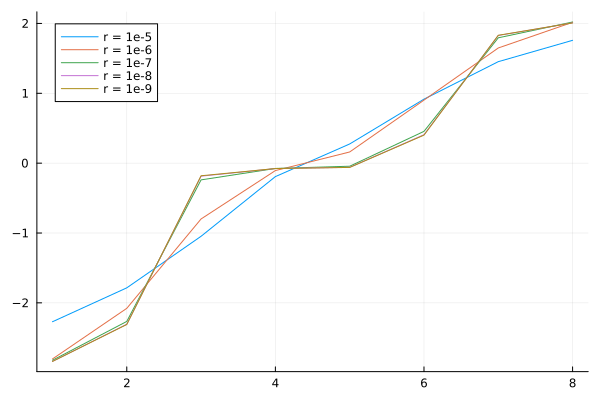

In [18]:
plot(1:8,w_r[1,:],label="r = 1e-5")
plot!(1:8,w_r[2,:],label="r = 1e-6")
plot!(1:8,w_r[3,:],label="r = 1e-7")
plot!(1:8,w_r[4,:],label="r = 1e-8")
plot!(1:8,w_r[5,:],label="r = 1e-9")

In [ ]:
plot(1:8,b_r[1,:],label="r = 1e-5")
plot!(1:8,b_r[2,:],label="r = 1e-6")
plot!(1:8,b_r[3,:],label="r = 1e-7")
plot!(1:8,b_r[4,:],label="r = 1e-8")
plot!(1:8,b_r[5,:],label="r = 1e-9")